In [1]:
import json
import os
from collections import Counter
from glob import glob

import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

In [15]:
# Load COCO JSON data
data_dir = '../../data/object_detection_dataset'
images_folder = os.path.join(data_dir, 'images')
annotations_path = os.path.join(data_dir, '_annotations.coco.json')
with open(annotations_path, 'r') as f:
	coco_data = json.load(f)

# Create DataFrame from images data
df_images = pd.DataFrame(coco_data['images'])

# Create DataFrame from annotations data  
df_annotations = pd.DataFrame(coco_data['annotations'])

# Create DataFrame from categories data
df_categories = pd.DataFrame(coco_data['categories'])

print("Images DataFrame shape:", df_images.shape)
print("Annotations DataFrame shape:", df_annotations.shape) 
print("Categories DataFrame shape:", df_categories.shape)

Images DataFrame shape: (298, 7)
Annotations DataFrame shape: (844, 7)
Categories DataFrame shape: (7, 3)


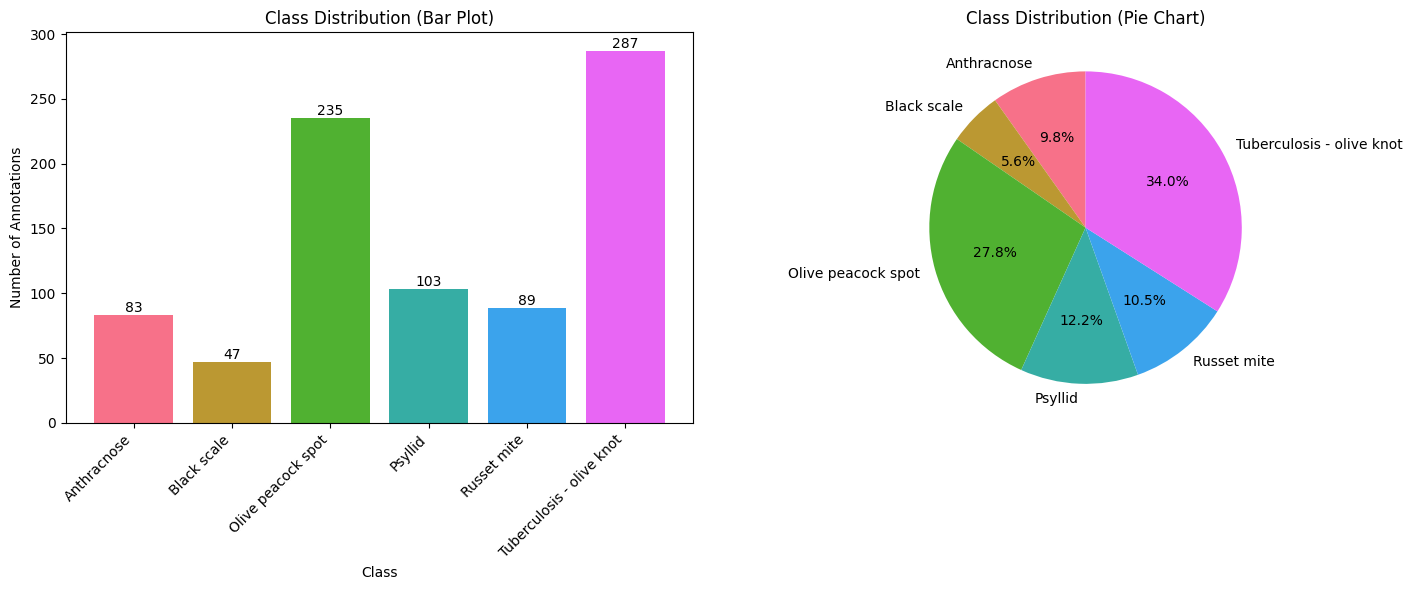

Class Distribution Summary:
----------------------------------------
Anthracnose: 83 annotations (9.8%)
Black scale: 47 annotations (5.6%)
Olive peacock spot: 235 annotations (27.8%)
Psyllid: 103 annotations (12.2%)
Russet mite: 89 annotations (10.5%)
Tuberculosis - olive knot: 287 annotations (34.0%)

Total annotations: 844
Number of classes: 6


In [16]:
# Set up the style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Get class distribution
class_counts = df_annotations['category_id'].value_counts().sort_index()
class_names = [cat['name'] for cat in coco_data['categories']]
class_ids = [cat['id'] for cat in coco_data['categories']]

# Create a mapping from category_id to class name
id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Create class distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
bars = ax1.bar(range(len(class_counts)), class_counts.values,
               color=sns.color_palette("husl", len(class_counts)))
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Annotations')
ax1.set_title('Class Distribution (Bar Plot)')
ax1.set_xticks(range(len(class_counts)))
ax1.set_xticklabels([id_to_name[idx]
                    for idx in class_counts.index], rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# Pie chart
wedges, texts, autotexts = ax2.pie(class_counts.values,
                                   labels=[id_to_name[idx]
                                           for idx in class_counts.index],
                                   autopct='%1.1f%%', startangle=90)
ax2.set_title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

# Print class distribution summary
print("Class Distribution Summary:")
print("-" * 40)
total_annotations = len(df_annotations)
for class_id in class_counts.index:
    count = class_counts[class_id]
    percentage = (count / total_annotations) * 100
    print(f"{id_to_name[class_id]}: {count} annotations ({percentage:.1f}%)")

print(f"\nTotal annotations: {total_annotations}")
print(f"Number of classes: {len(class_counts)}")

Images with Bounding Box Annotations

ANTHRACNOSE
-----------


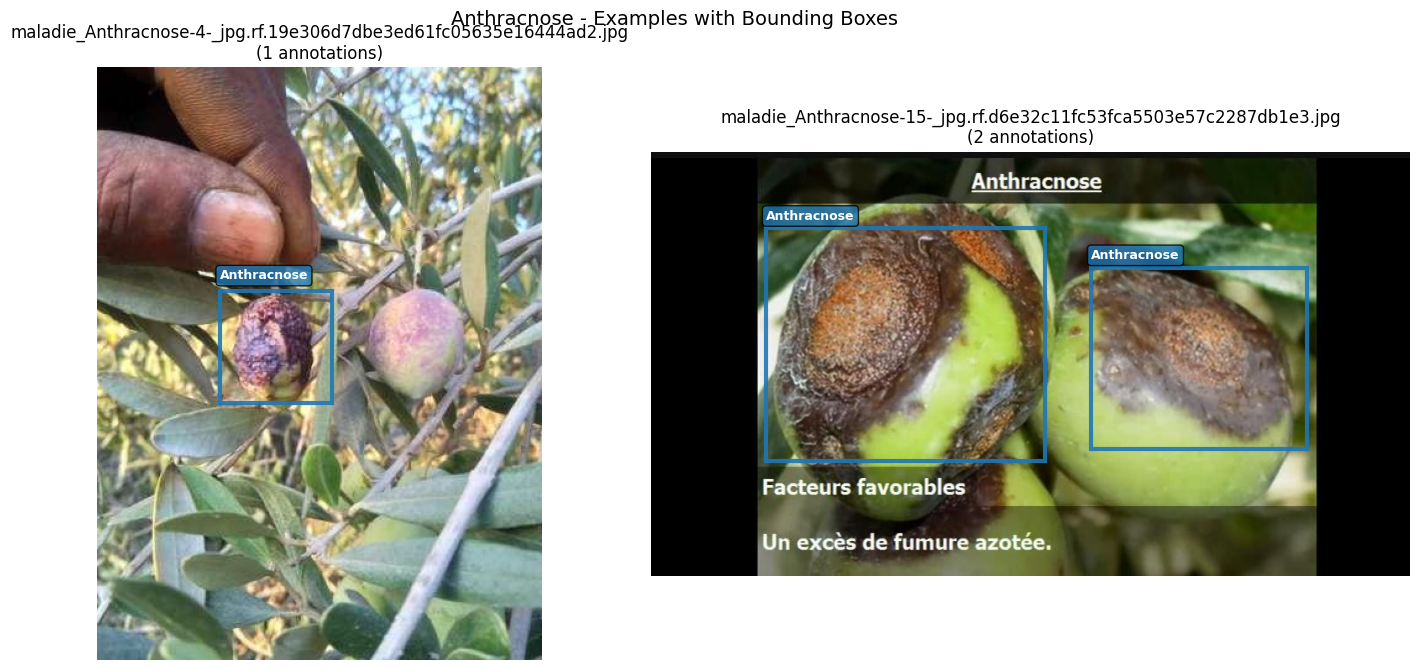


BLACK SCALE
-----------


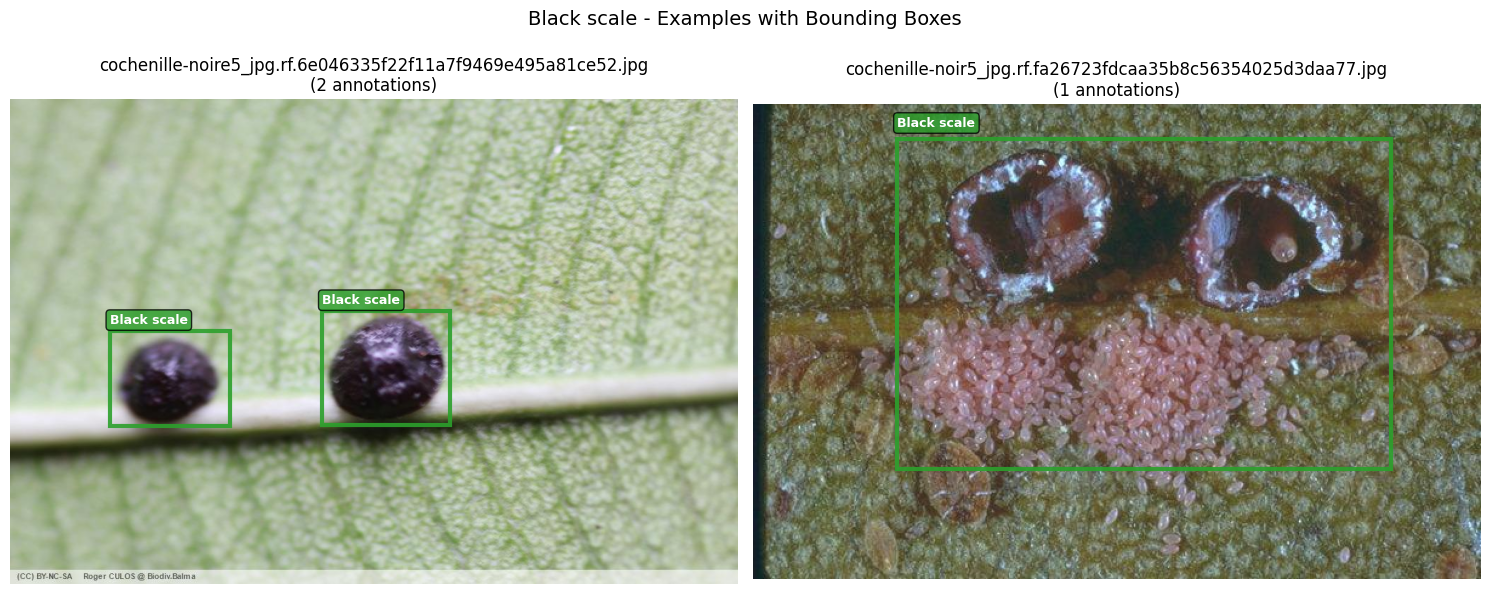


OLIVE PEACOCK SPOT
------------------


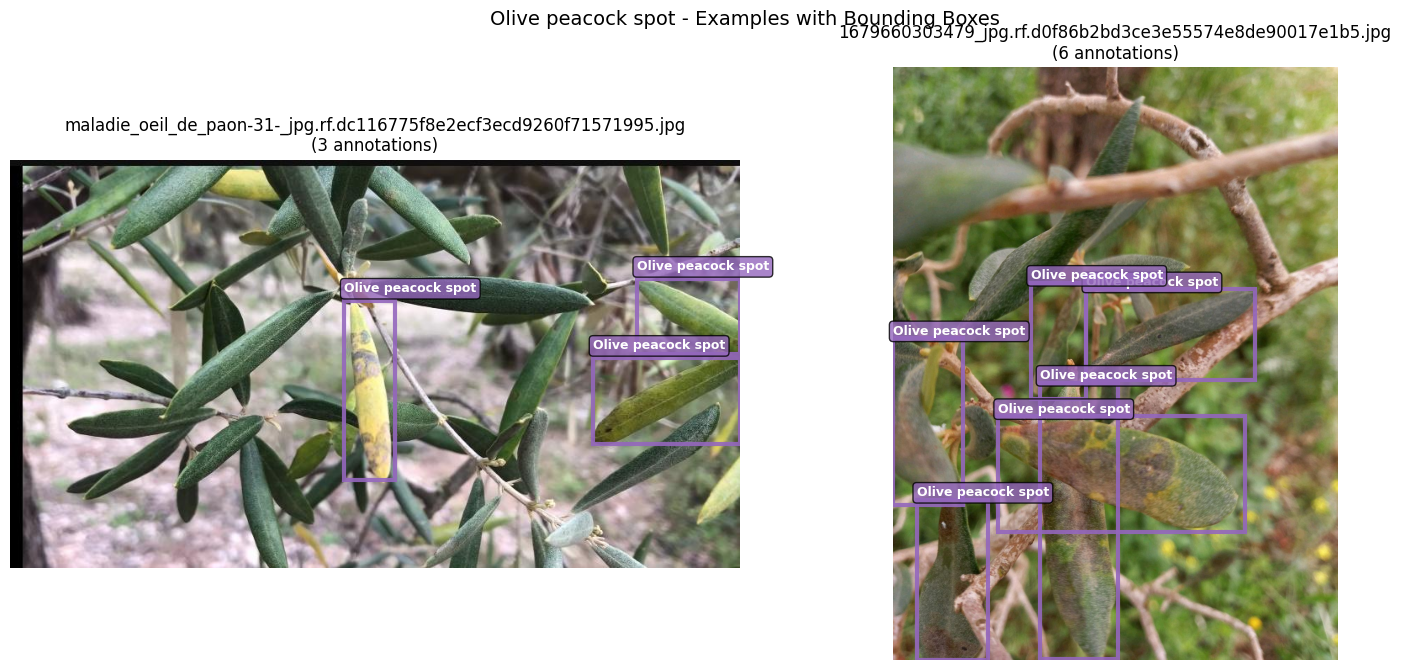


PSYLLID
-------


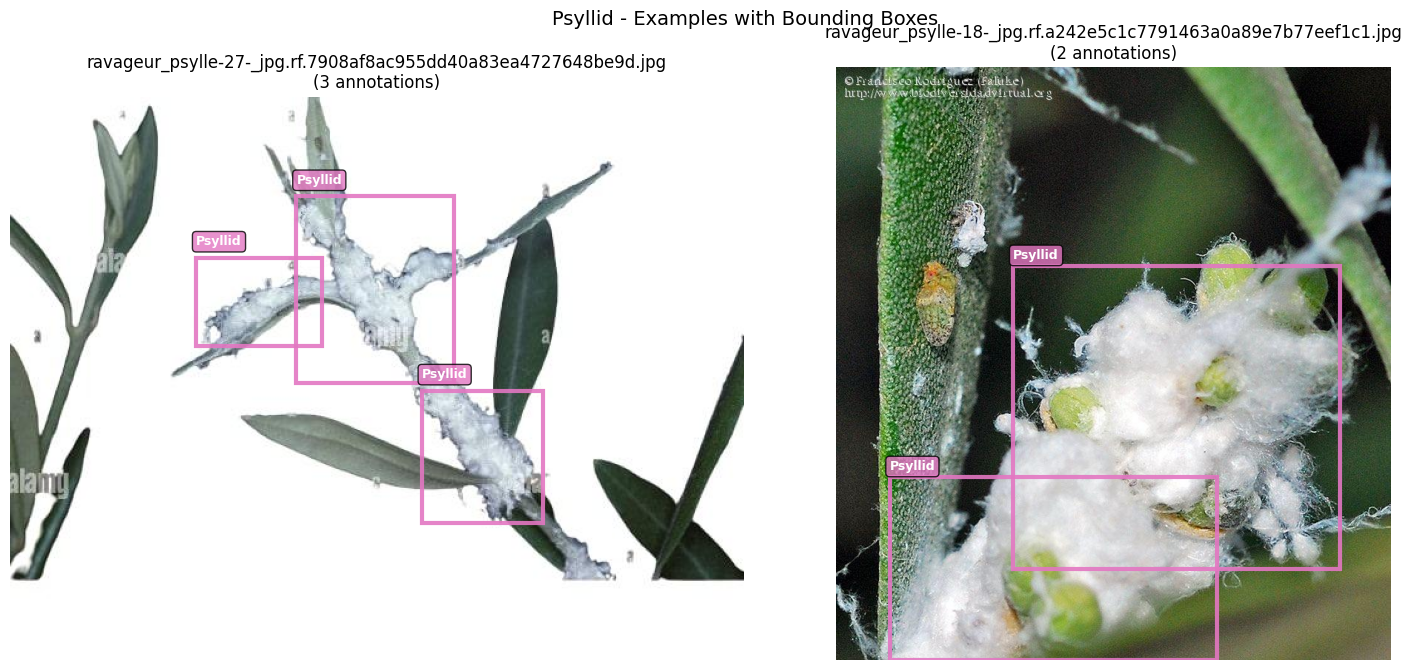


RUSSET MITE
-----------


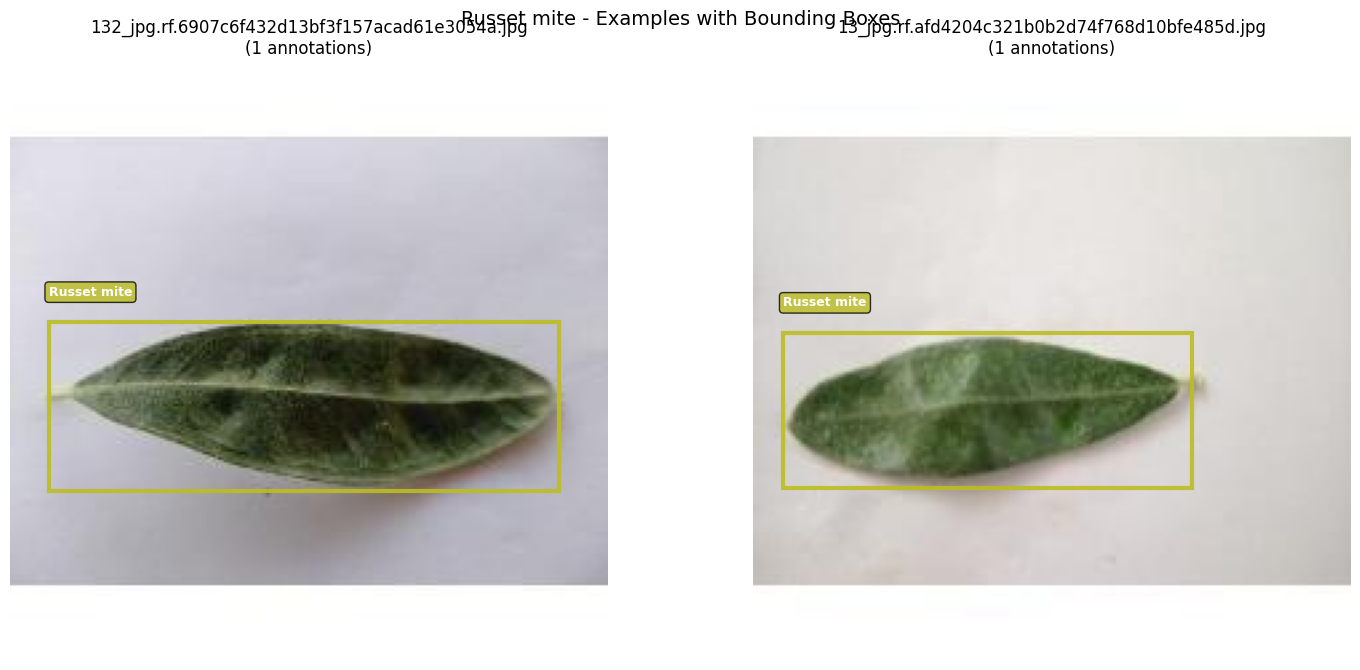


TUBERCULOSIS - OLIVE KNOT
-------------------------


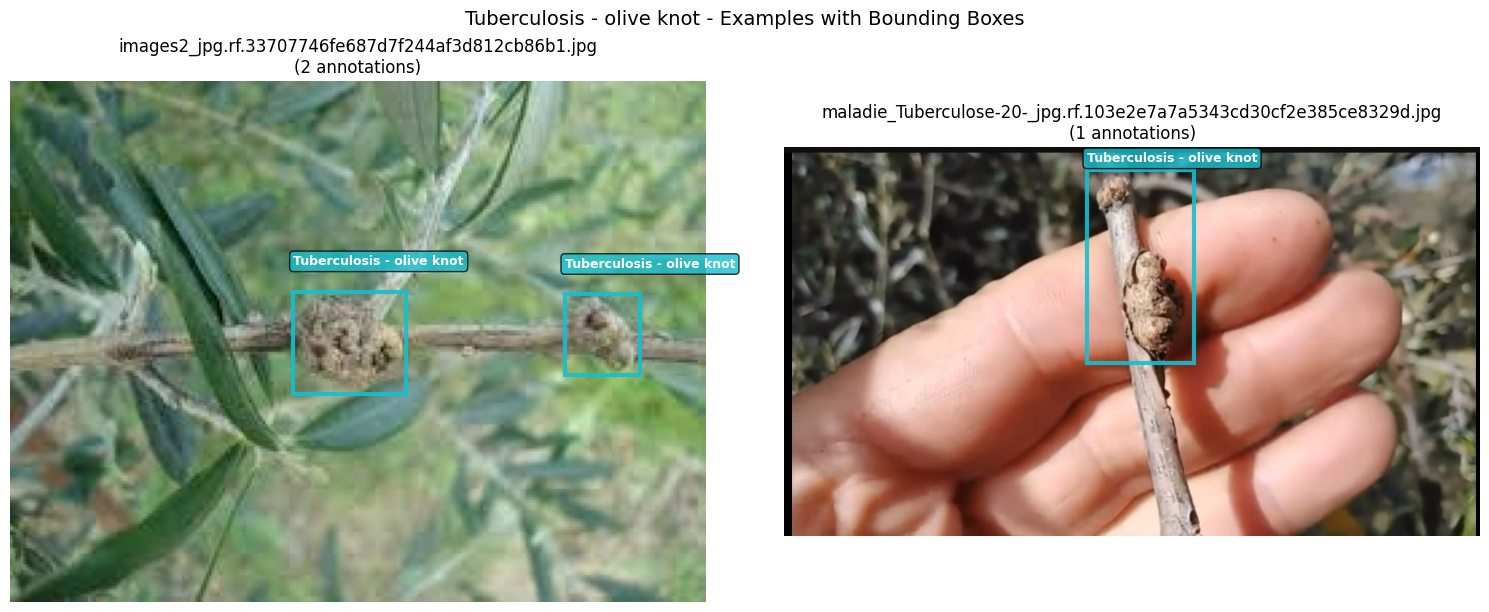

In [17]:
def get_annotations_for_image(image_id):
    """Get all annotations for a specific image"""
    return df_annotations[df_annotations['image_id'] == image_id]


def draw_bbox_on_image(img_path, annotations, class_colors):
    """Draw bounding boxes on image and return the figure and axis"""
    # Load image
    img = Image.open(img_path)
    img_array = np.array(img)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img_array)

    # Draw bounding boxes
    for _, ann in annotations.iterrows():
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']

        # Create rectangle patch
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor=class_colors[category_id],
            facecolor='none', alpha=0.8
        )
        ax.add_patch(rect)

        # Add class label
        class_name = id_to_name[category_id]
        ax.text(bbox[0], bbox[1]-5, class_name,
                bbox=dict(boxstyle="round,pad=0.3",
                          facecolor=class_colors[category_id], alpha=0.7),
                fontsize=10, color='white', weight='bold')

    ax.axis('off')
    return fig, ax


# Create color mapping for classes
colors = plt.cm.tab10(np.linspace(0, 1, len(class_counts)))
class_colors = {class_id: colors[i]
                for i, class_id in enumerate(sorted(class_counts.index))}

# Display images with bounding boxes for each class (2 examples per class)
print("Images with Bounding Box Annotations")
print("=" * 50)

for class_id in sorted(class_counts.index):
    class_name = id_to_name[class_id]
    print(f"\n{class_name.upper()}")
    print("-" * len(class_name))

    # Get images for this class
    class_annotations = df_annotations[df_annotations['category_id'] == class_id]
    unique_image_ids = class_annotations['image_id'].unique()[
        :2]  # Get 2 images

    # Create subplots for this class
    fig, axes = plt.subplots(1, len(unique_image_ids), figsize=(15, 7))
    if len(unique_image_ids) == 1:
        axes = [axes]

    for idx, img_id in enumerate(unique_image_ids):
        # Get image info
        img_info = df_images[df_images['id'] == img_id].iloc[0]
        img_path = os.path.join(images_folder, img_info['file_name'])

        # Get all annotations for this image (might have multiple classes)
        img_annotations = get_annotations_for_image(img_id)

        if os.path.exists(img_path):
            # Load and display image
            img = Image.open(img_path)
            img_array = np.array(img)
            axes[idx].imshow(img_array)

            # Draw bounding boxes
            for _, ann in img_annotations.iterrows():
                bbox = ann['bbox']  # [x, y, width, height]
                ann_category_id = ann['category_id']

                # Create rectangle patch
                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), bbox[2], bbox[3],
                    linewidth=3, edgecolor=class_colors[ann_category_id],
                    facecolor='none', alpha=0.9
                )
                axes[idx].add_patch(rect)

                # Add class label
                ann_class_name = id_to_name[ann_category_id]
                axes[idx].text(bbox[0], bbox[1]-10, ann_class_name,
                               bbox=dict(
                                   boxstyle="round,pad=0.3", facecolor=class_colors[ann_category_id], alpha=0.8),
                               fontsize=9, color='white', weight='bold')

            axes[idx].set_title(
                f'{img_info["file_name"]}\n({len(img_annotations)} annotations)')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'Image not found:\n{img_info["file_name"]}',
                           ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis('off')

    plt.suptitle(f'{class_name} - Examples with Bounding Boxes',
                 fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()